In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

metadata_frame = pd.read_csv("/Users/lukasadamek/Projects/GenerativePlayground/datasets/unzipped/metadata.csv")

In [2]:
metadata_frame

,Unnamed: 0,image_shape,last_image_dimension,shape_dim_zero,shape_dim_one,filename
0,0,3,3,800,532,/Users/lukasadamek/Projects/GenerativePlaygrou...
1,1,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
2,2,3,3,1584,1002,/Users/lukasadamek/Projects/GenerativePlaygrou...
3,3,3,3,1754,1280,/Users/lukasadamek/Projects/GenerativePlaygrou...
4,4,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
...,...,...,...,...,...,...
6968,6968,3,3,1024,683,/Users/lukasadamek/Projects/GenerativePlaygrou...
6969,6969,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
6970,6970,3,3,636,500,/Users/lukasadamek/Projects/GenerativePlaygrou...
6971,6971,3,3,900,600,/Users/lukasadamek/Projects/GenerativePlaygrou...


In [3]:
len(metadata_frame.query("shape_dim_zero == shape_dim_one"))

1966

In [4]:
len(metadata_frame.query("(abs(shape_dim_zero - shape_dim_one)/shape_dim_one) < 0.15"))

2172

In [5]:
cleaned_frame = metadata_frame.query("(abs(shape_dim_zero - shape_dim_one)/shape_dim_one) < 0.15")
cleaned_frame = cleaned_frame.query("(image_shape == 3) and (last_image_dimension == 3) and (shape_dim_zero >= 500) and (shape_dim_one >= 500)")

In [6]:
import cv2

class ImageLoader:
    def __init__(self, file_list, resize = None, return_fname = False):
        self.file_list = file_list
        self.resize = resize
    
    def __getitem__(self, i):
            img, filename = plt.imread(self.file_list[i]), self.file_list[i]
            if self.resize is not None:
                img = cv2.resize(img, (600, 600), interpolation=cv2.INTER_AREA)
            img = img / 255.0
            return img, filename
    
    def __len__(self):
        return len(self.file_list)


In [7]:
loader = ImageLoader(cleaned_frame["filename"].values, resize=(600,600))

In [8]:
loader[0]

(array([[[0.35686275, 0.24705882, 0.16078431],
         [0.35294118, 0.24313725, 0.15686275],
         [0.35294118, 0.24313725, 0.15686275],
         ...,
         [0.41568627, 0.40392157, 0.32941176],
         [0.41176471, 0.4       , 0.3254902 ],
         [0.41176471, 0.4       , 0.3254902 ]],
 
        [[0.34901961, 0.23921569, 0.15294118],
         [0.34509804, 0.23529412, 0.14901961],
         [0.34509804, 0.23529412, 0.14901961],
         ...,
         [0.41568627, 0.40392157, 0.32941176],
         [0.41568627, 0.40392157, 0.32941176],
         [0.41568627, 0.40392157, 0.32941176]],
 
        [[0.35294118, 0.24313725, 0.15686275],
         [0.35294118, 0.24313725, 0.15686275],
         [0.34901961, 0.23921569, 0.15294118],
         ...,
         [0.41568627, 0.40392157, 0.32941176],
         [0.41568627, 0.40392157, 0.32941176],
         [0.41568627, 0.40392157, 0.32941176]],
 
        ...,
 
        [[0.09411765, 0.07843137, 0.0745098 ],
         [0.09411765, 0.07843137, 0.07450

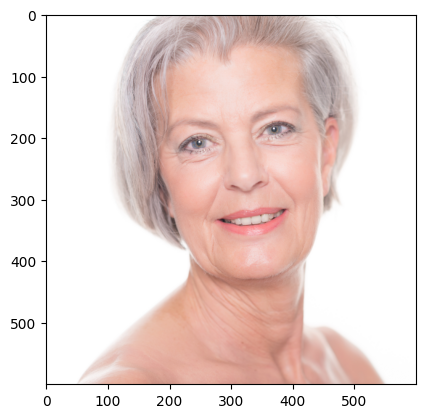

In [9]:
plt.imshow(loader[505][0])

In [10]:
import tensorflow as tf
import tensorflow.keras as keras

generator = keras.models.Sequential()
generator.add(keras.layers.Conv2D(3, (3, 3), padding="SAME", activation='relu', input_shape=(600, 600, 3)))
generator.add(keras.layers.Conv2D(6, (5, 5), padding="SAME", activation='relu'))
generator.add(keras.layers.Conv2D(9, (5, 5), padding="SAME", activation='relu'))
generator.add(keras.layers.Conv2D(6, (5, 5), padding="SAME", activation='relu'))
generator.add(keras.layers.Conv2D(3, (5, 5), padding="SAME", activation='relu'))
generator.add(tf.keras.layers.Activation("sigmoid"))

scorer = keras.models.Sequential()
scorer.add(keras.layers.Conv2D(3, (3, 3), activation='relu', input_shape=(600, 600, 3)))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Conv2D(3, (5, 5), activation='relu'))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Conv2D(1, (5, 5), activation='relu'))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Flatten())
scorer.add(keras.layers.Dense(1, activation="linear"))

2023-06-08 22:03:18.255950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
import numpy as np
scorer(np.array([loader[0][0], loader[1][0]]))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.05956948],
       [-0.19400138]], dtype=float32)>

In [13]:
scorer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 598, 598, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 3)      0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 145, 145, 3)       228       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 3)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 1)         76        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 1)         

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 600, 3)       84        
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 600, 6)       456       
                                                                 
 conv2d_2 (Conv2D)           (None, 600, 600, 9)       1359      
                                                                 
 conv2d_3 (Conv2D)           (None, 600, 600, 6)       1356      
                                                                 
 conv2d_4 (Conv2D)           (None, 600, 600, 3)       453       
                                                                 
 activation (Activation)     (None, 600, 600, 3)       0         
                                                                 
Total params: 3,708
Trainable params: 3,708
Non-trainabl

In [15]:
import numpy as np
import keras

class RealDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_loader, batch_size=12, image_size=(600,600)):
        self.image_loader = image_loader
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.image_loader) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        data = np.stack([self.image_loader[i][0] for i in indexes])
        return data, np.ones(len(data))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_loader))
        np.random.shuffle(self.indexes)

class FakeDataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=12, shape=(600, 600, 3), length=1000):
        self.length=length
        self.batch_size=batch_size
        self.shape=shape
        self.on_epoch_end()
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return np.random.uniform(low=0.0, high=1.0, size=(self.batch_size, *self.shape)), np.zeros(shape=(self.batch_size))
    
    def on_epoch_end(self):
        pass

class MergedDataGenerator(keras.utils.Sequence):
    def __init__(self, gen1, gen2):
        self.gen1=gen1
        self.gen2=gen2
        assert len(gen1) == len(gen2)
    
    def __len__(self):
        return len(self.gen1)
    
    def __getitem__(self, index):
        x1, y1 = self.gen1[index]
        x2, y2 = self.gen2[index]
        return np.concatenate([x1,x2]), np.concatenate([y1,y2])
    
    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()

In [16]:
real_generator = RealDataGenerator(loader, batch_size=4)
fake_generator = FakeDataGenerator(batch_size=4, length=len(real_generator))
full_generator = MergedDataGenerator(real_generator, fake_generator)

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, critic, generator):
        super().__init__()
        self.generator = generator
        self.critic = critic
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn_gen, loss_fn_critic):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn_gen = loss_fn_gen
        self.loss_fn_critic = loss_fn_critic

    def train_step(self, data):
        x, y = data
        
        # Train the critic.
        with tf.GradientTape() as tape:
            criticized_real = self.critic(x[y==1])
            criticized_fake = self.critic(self.generator(x[y==0]))
            d_loss = self.loss_fn_critic(criticized_real, criticized_fake)
        grads = tape.gradient(d_loss, self.critic.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.critic.trainable_weights)
        )

        # Train the generator.
        with tf.GradientTape() as tape:
            criticized_fake = self.critic(self.generator(x[y==0]))
            g_loss = self.loss_fn_gen(criticized_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
cond_gan = ConditionalGAN(
    scorer, generator
)

def critic_loss(criticized_real, criticized_fake):
    return  (-1) * tf.math.reduce_mean(criticized_real) + tf.math.reduce_mean(criticized_fake)

def generator_loss(criticized_fake):
    return (-1) * tf.math.reduce_mean(criticized_fake)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn_gen=generator_loss,
    loss_fn_critic=critic_loss,
)

cond_gan.fit(full_generator, epochs=1)

2023-06-08 22:04:18.583068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


174/525 [========>.....................] - ETA: 20:39 - g_loss: -0.0446 - d_loss: -0.0091

In [ ]:
plt.imshow(generator(np.random.uniform(low=0.0, high=1.0, size=(1, *(600,600,3))))[0])

In [ ]:
generator(np.random.uniform(low=-1.0, high=1.0, size=(1, *(600,600,3))))[0]